## Example using quantatative pipeline for HIV's region RRE

In [2]:
%matplotlib inline

import re
import os
import sys
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import matplotlib.pyplot as plt
import itertools
from joblib import load

# adding project folder to lib search path
project = "/".join((os.path.split(os.getcwd())[0], os.path.split(os.getcwd())[1], 'scripts'))
if project not in sys.path:
    sys.path.append(project)
    
from loader import *
import work_with_files
import patients_and_translation
import phylo_tree
import classificator_k_mer
from data_prep_k_mer import *
from calculating_metrics import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### Preparing data

In [10]:
hiv_regions = patients_and_translation.get_regions()

In [17]:
patients = patients_and_translation.get_patients()

In [16]:
# working with files

for patient in patients:
    # converting json to fasta
    work_with_files.json2fasta('data/', f'data/hivevo_{patient}_RRE.fasta')
    
    # extracting exact region from reference file (it is in json format too)
    work_with_files.extracting_region_from_reference('RRE', f'data/references/hivevo_reference_{patient}.fasta', 
                                                     'data/references/')
    
    # adding extracted region to hivevo_%patient%_RRE.fasta
    work_with_files.add_ref_reg2fasta(f'data/fasta/hivevo_{patient}_RRE.fasta', 
                                      f'data/references/RRE/hivevo_reference_{patient}_RRE.fasta')

### Classification

In [8]:
# Function to create graphs for 2-mers analyze

def clf_metric_2_mer_path(path_tree, prot_dict, aa_k_mer_list):
    """
    Converting sequence from path_tree into object that can be used in our classificator
    
    Args:
        path_tree: list, list with names of haplotypes in exact path in tree 
        prot_dict: dict, 
        aa_k_mer_list: list, all posible k-mers from aminoacids
    
    Returns:
        list of all possible aminoacid k-mer sequences
    """
    metric_path = []
    
    # for-loop for names in path_tree
    for name in path_tree:
        metric_path.append([])
        # finding prot for exact name
        prot = prot_dict[name]
        # finding frequency metrics
        tmp = finding_freq_single_protein(prot, aa_k_mer_list)
        
        # KOCTblJLb (our vector from finding_freq_bla_bla is not feeling well (my bad :))
        for x in tmp:
            metric_path[-1].append(float(x[0]))
        
    return metric_path

In [10]:
# Our classificator

forest_2_mer = load('saved_sklearn_models/forest.joblib')

In [20]:
def graph_patients(patients, region):
    """
    Function to analyze all paths in created Phylo_tree for each patient. 
    Here probability to be human's protein is stored in Y, which then will be plotted. 
    Args:
        patients: list, list of all patients
    Return:
        pat_X: list, list of Xs, X = [days, when patient was sequenced]
        pat_Y: list, list of Ys, Y = [probability in particular day]; X and Y are connected (have same lengths)
    """
    
    # Our lists
    pat_X = []
    pat_Y = []
    
    patients_used = []
    
    aa_k_mer_list = making_aa_k_mers(2)
    
    # for-loop for patients
    for patient in patients:

        # We will not use patient#3 and patient#10 because their HIV wasn't cool at all
        # joke, additional info can be found here (https://elifesciences.org/articles/11282)
        
        if patient != 'p3' and patient != 'p10':
            
            patients_used.append(patient)
            
            # reading fasta
            haplo_seq_dict, days = work_with_files.read_fasta_haplo(f'data/fasta/hivevo_{patient}_{region}.fasta')
            
            # using all our AOE-skills and mana on it
            
            seq_dict, seq_name_days_dict = patients_and_translation.preparing_data(haplo_seq_dict, days)
            prot_dict = patients_and_translation.translating_seqs(seq_dict)

            # Constructing tree
            tree = phylo_tree.Phylo_tree()
            tree.construct_levels(days)
            tree.constructing_tree(seq_dict, seq_name_days_dict)
            phylo_paths = tree.create_all_path()
            
            # Making X
            X = list(map(int, days))
            X.insert(0, 0)
            pat_X.append(X)
            pat_Y.append([])
            
            # Using classificator to find out probability to be human's gene
            for path in phylo_paths:
                met = clf_metric_2_mer_path(path, prot_dict, aa_k_mer_list)
                Y = forest_2_mer.predict_proba(met)[:, 1]
                pat_Y[-1].append(Y)
            
    return pat_X, pat_Y, patients_used

pat_X, pat_Y, patients_used = graph_patients(patients, 'RRE')

In [21]:
# Making font BIGGER!

plt.rcParams['font.size'] = 20

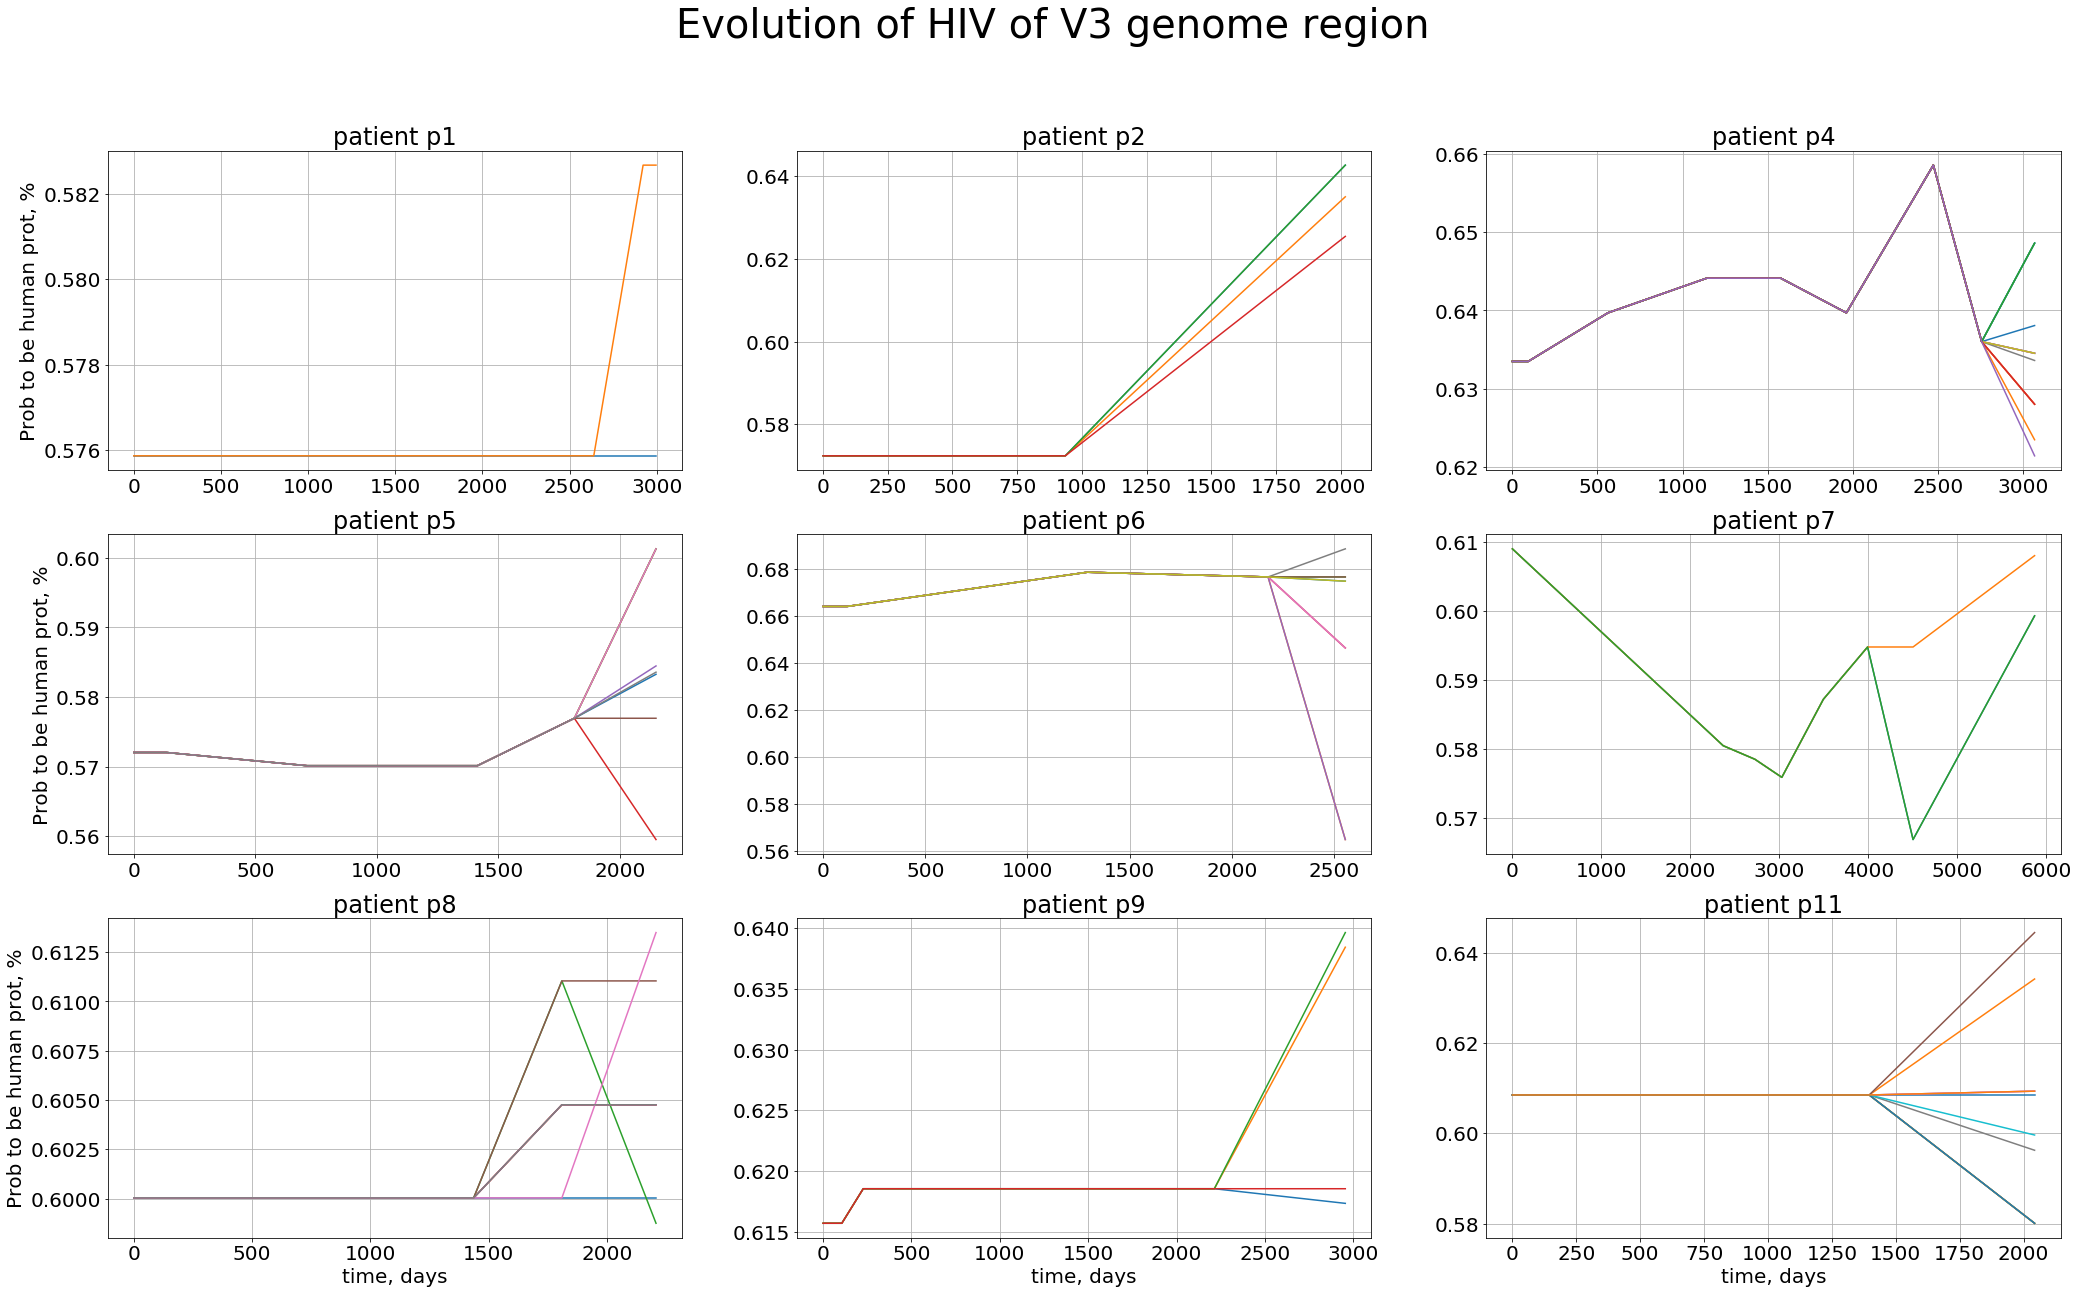

In [22]:
# Plotting

fig, axs = plt.subplots(3, 3, figsize = (35, 20), sharex = 'none', sharey = 'none')
#fig.figsize = (20, 16)
i = 0
for x in range(3):
    for y in range(3):
        for Y in pat_Y[i]:
            axs[x, y].plot(pat_X[i], Y)
            axs[x, y].set_title('patient {}'.format(patients_used[i]))
        axs[x, y].grid(alpha=1)
        i += 1

# Sadly it should be here because of my newbie skills in pyplot
axs[0, 0].set(ylabel='Prob to be human prot, %')
axs[1, 0].set(ylabel='Prob to be human prot, %')
axs[2, 0].set(ylabel='Prob to be human prot, %')

axs[2, 0].set(xlabel='time, days')
axs[2, 1].set(xlabel='time, days')
axs[2, 2].set(xlabel='time, days')

fig.suptitle('Evolution of HIV of V3 genome region', fontsize = 40)
#plt.savefig('graphs.png', quality=100, bbox_inches='tight')
plt.savefig('results/frequency_2_mer_plot/2_mer_plot_RRE.png')